<a href="https://colab.research.google.com/github/5amessi/Yolo-FaceDetection/blob/master/YoloFD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
!wget http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
import zipfile
path = "/content/drive/My Drive/WIDER_train.zip"
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall("")
zip_ref.close()
path = "/content/wider_face_split.zip"
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall("")
zip_ref.close()

--2019-12-24 20:01:05--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  --.-KB/s    in 0.1s    

2019-12-24 20:01:06 (29.9 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]

--2019-12-24 20:01:09--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624 [application/zip]
Saving to: ‘Submission_example.zip’

Submission_example. 100%[===================>]     

In [0]:
#import libs
import os
import os.path as path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras import backend as K
from PIL import Image
import pandas as pd
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.applications import VGG19 ,inception_v3
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def GenerateBatch(i,END):
  annotations = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
  lines = annotations.readlines()
  numOfLines = len(lines)
  NOF = 0
  j = 0
  h = w = 4
  c = 1
  Label = []
  inp = []
  while i<END and i < numOfLines:
    numOfFace= int(lines[i+1])
    if(int(numOfFace) <= ((h-1)*(w-1))):
      imgName=str(lines[i].rstrip('\n'))
      path = "/content/WIDER_train/images/"+imgName
      img = cv2.imread(path)
      inp.append(cv2.resize(img,(500,500),interpolation = cv2.INTER_AREA))
      visted = [0]*2000
      liney = []
      for y in range(c,h,c):
        linex = []
        for x in range(c,w,c):
          check = False
          for k in range(i+2,i+numOfFace+2):
            if not visted[k-i-2]:
              bx = list(map(int,lines[k].split(' ')[:-1]))
              Ny, Nx, Nw, Nh = bx[1]/img.shape[0] ,bx[0]/img.shape[1], bx[2]/img.shape[1], bx[3]/img.shape[0]
              if(Nx <= (x/w) and Nx > ((x-c) / w) and Ny <= (y/h) and Ny > ((y-c) / h) ):
                linex.append([1,Nx/(x/w),Ny/(y/h),Nw,Nh])
                check = True
                visted[k-i-2] = 1
                break
          if check == False:
            linex.append([0,0,0,0,0])
        liney.append(linex)
          
      Label.append(liney)
    i+= max(numOfFace,1)+2
    
  return i , np.array(inp) , np.array(Label)

In [0]:
# x_train, x_test, y_train ,y_test = train_test_split(x, y, test_size=0.1, random_state=50)
baseMapNum = 16
weight_decay = 1e-4

In [0]:
#building classifer 
def C_N_N():
    model = Sequential()
    model.add(Conv2D(8*baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=(500,500, 3),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(8*baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))

    model.add(Conv2D(4 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(4 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))  

    model.add(Conv2D(2 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(2 * baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))  
   
    model.add(Conv2D(baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(Conv2D(baseMapNum, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation=LeakyReLU(alpha=0.1)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.1))    

    model.add(Conv2D(5, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),activation='sigmoid'))

    return model

In [0]:
#compile it
model = C_N_N()
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.adam(), metrics=['mse'])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 500, 500, 128)     3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 500, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 500, 128)     147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 500, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 166, 166, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 166, 166, 128)     0        

In [0]:
#Train the model, If you want to train uncomment next lines
annotations = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')
numOfLines = len(annotations.readlines())
i=0
while i < numOfLines:
  i, x, y = GenerateBatch(i,10000+i)
  print(i)
  model.fit(x, y, epochs=1000, batch_size=8, verbose=1)
  model.save_weights("weights.h5")


(4, 3, 3, 5)
[1.         0.87695312 0.95306859 0.11914062 0.10758123]
[0.99221504 0.7233219  0.6286556  0.09886158 0.10885286]
36 15 49 54


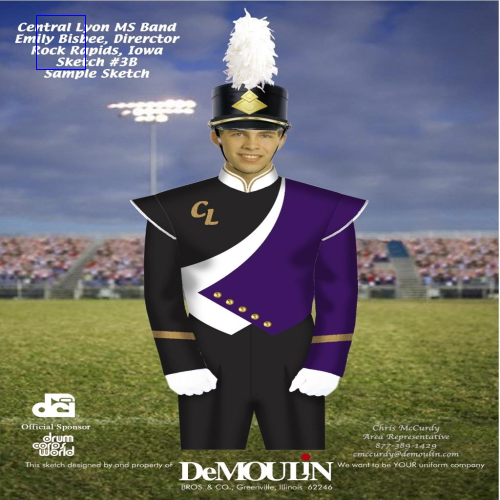

In [0]:
_, tempx, ty = GenerateBatch(0,1000)
tempy = model.predict(tempx)

print(np.shape(ty))

print(ty[0][0][1])

print(tempy[0][0][1])

for yy in range (0,3):
  for xx in range(0,3):
    i = tempy[0][yy][xx]
    if(float(i[0]) > 0.5):
      img = tempx[0]
      hh = np.shape(img)[0]
      ww = np.shape(img)[1]
      x1 = int(i[1]*((xx+1)/20)*ww)
      y1 = int(i[2]*((yy+1)/20)*hh)
      w = int(i[3]*ww)
      h = int(i[4]*hh)
      print(x1,y1,w,h)
      cv2.rectangle(img, (x1,y1), (w+x1,h+y1), (255,0,0)) 
      cv2_imshow(img)


In [0]:
model.save_weights("/content/drive/My Drive/Face Detection/weights.h5")

In [0]:
# predicted = model.predict(x)
# predicted = np.reshape(predicted,(1,3*3,5))
# for i in predicted[0]:
#   if(float(i[0]) > 0.5):
#     print(i)
# print(np.sum(predicted,axis = 1))
# print(np.sum(np.reshape(y,(1,3*3,5)),axis = 1))

ValueError: ignored